# AIM
<div style = "text-align: justify">Using U-net, localize the area which contains tumor growth <b>(which cannot be easily determined by looking at the actual medical images)</b> and compare it against the mask images. Then by looking at the generated mask image, classify whether the tumor growth is <b>malignant, benign or normal.</b> Then we must also classify the masks.</div>

# Note
<div style = "text-align: justify">Later in the notebook, I have mentioned images taken from medical imaging as <b>real image</b> !!!</div>

# Dataset [Link](https://www.kaggle.com/aryashah2k/breast-ultrasound-images-dataset)

# Please checkout the [U-net paper](https://arxiv.org/pdf/1505.04597.pdf)

# Import images

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras

In [11]:
import os

In [12]:
path = 'drive/MyDrive/Dataset_BUSI_with_GT/'

In [13]:
from keras.preprocessing.image import img_to_array

**Helper function** to get the index for real image and mask.

In [14]:
def num (image) :
    
    val = 0
    
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    
    return val

<div style = "text-align: justify">Initialize the arrays for benign, normal and malignant tumors, both real and mask. As already given the number of samples in benign, normal & malignant are <b>437, 133 and 210</b> respectively.</div>

In [15]:
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m = np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [16]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            try:
              img = cv2.resize(img,(128,128))
              pil_img = Image.fromarray (img)
            except Exception as e:
              print(str(e))
  
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

Visualize the results to verify the above method

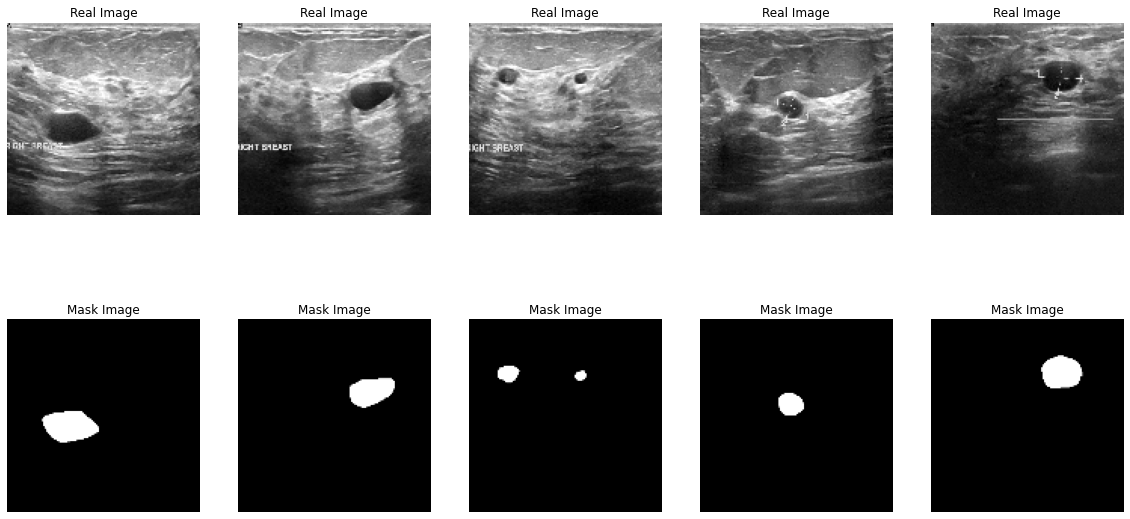

In [17]:
plt.figure(figsize = (20,10))

for i in range(5) :
    plt.subplot(2,5,i+1)
    plt.imshow(X_b[i+1].reshape(128,128), 'gray')
    plt.title('Real Image')
    plt.axis('off')

for i in range(5) :
    plt.subplot(2,5,i+6)
    plt.imshow(y_b[i+1].reshape(128,128), 'gray')
    plt.title('Mask Image')
    plt.axis('off')
plt.show()

In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

### Why did I take these pixelated masks instead of taking original size ?
<div style = "text-align: justify">I did try to take large image sizes, <b>but due to GPU and RAM constraints</b>, my kernel kept on crashing. So I went with smaller sizes. I encourage the reader to try some different sizes where masks are more accurate.</div>

# Create datasets for model training and validation

In [19]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [20]:
X /= 255.0
y /= 255.0

In [21]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [22]:
print(X.max())
print(X.min())

1.0
0.0


In [23]:
print(y.max())
print(y.min())

2.0
0.0


In [24]:
y[y > 1.0] = 1.0

In [25]:
print(y.max())
print(y.min())

1.0
0.0


# Visualization

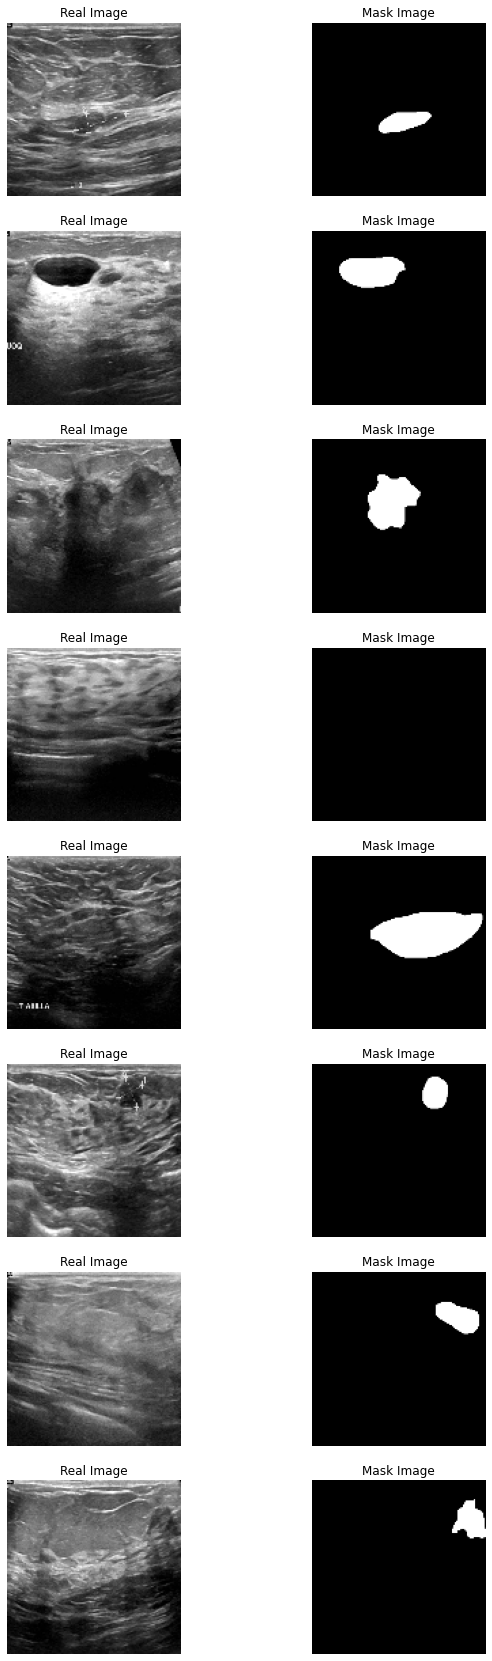

In [26]:
plt.figure(figsize = (10,30))
i = 0
while i < 16 :
    
    x = np.random.randint(0,780)
    
    plt.subplot(8,2,i+1)
    plt.imshow(X[x].reshape(128,128),'gray')
    plt.title('Real Image')
    plt.axis('off')
    
    plt.subplot(8,2,i+2)
    plt.imshow(y[x].reshape(128,128),'gray')
    plt.title('Mask Image')
    plt.axis('off')
    
    i += 2
plt.show()

<div style = "text-align: justify"> <b>Take a good look at image 2 and 8</b> and think if the masks were not provided, then would it have been easy to know the location tumor. NO !!! This is the aim of U-net model, localize the abnormalities in the image itself. Let's see the implementation.</div>

# Train test split

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 1)

In [29]:
print(X_train.shape)
print(y_train.shape)

(741, 128, 128, 1)
(741, 128, 128, 1)


In [30]:
print(X_test.shape)
print(y_test.shape)

(39, 128, 128, 1)
(39, 128, 128, 1)


# Model Creation [U-net](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)
<img src = "https://miro.medium.com/max/3600/1*f7YOaE4TWubwaFF7Z1fzNw.png"/>

### Basic Architecture
<div style = "text-align: justify">U-net architecture can localize the area of interest. It was first used in Biomedical imaging. The reason it is able to <b>distinguish and localize</b> the area is by classifying every pixel in the input image. <b>So the size of input and output images is the same</b>. It comprises of two paths - <b>Contracting path and Expanding path</b>.</div>

### Contract Path
The Contracting path has two Convolutional layers and a Maxpooling layer.

### Expansive Path
<div style = "text-align: justify">The Expanding path consists of both transpose Convolutional layer and two Convolutional layers. The corresponding image from contracting path is fed to this layer for precise predictions.</div>

### Modifications
<div style = "text-align: justify">I kept the padding same so that I can get the mask of exact same dimensions as the actual image. The adam gradient descent was used with a small <b>learning rate of 0.00005</b>. Also I am planning to add BatchNormalization which was discovered after U-net. </div>

In [31]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Concatenate
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose

from keras import Model

### Contracting path

In [32]:
inply = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

### Bottleneck layer

In [33]:
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

### Expanding layer

In [34]:
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [35]:
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

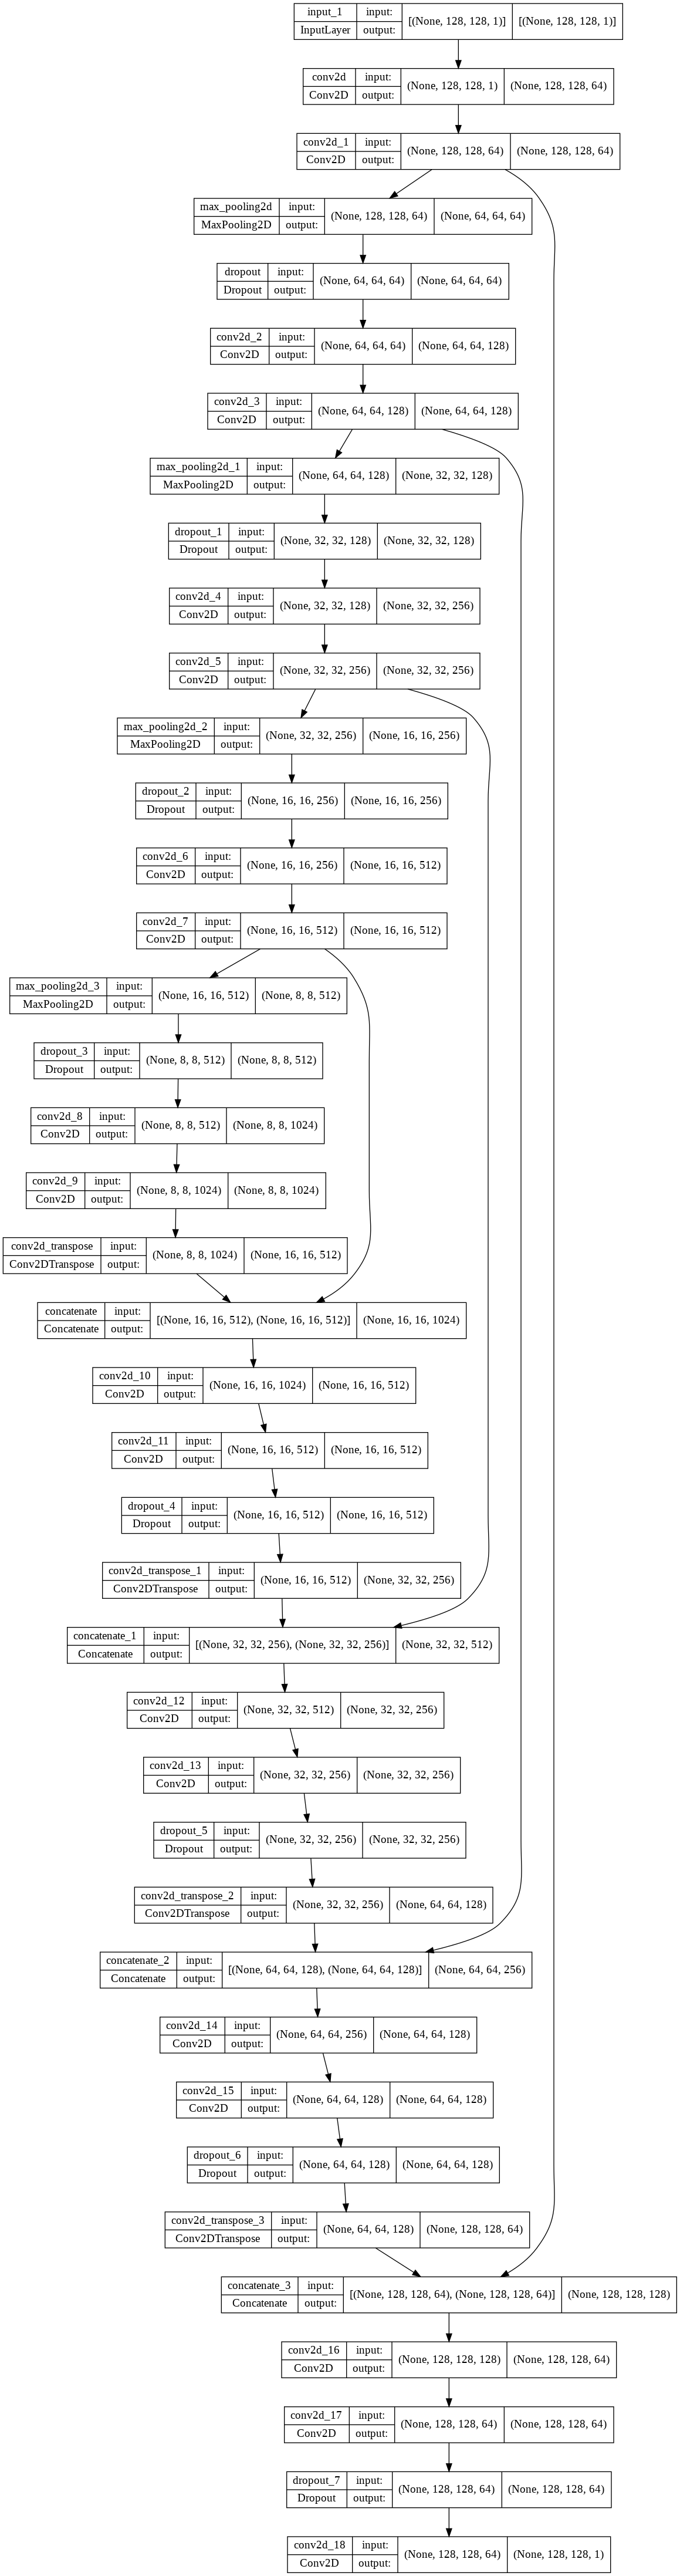

In [36]:
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

# Loss function

<div style = "text-align: justify">The loss for evaluating the performance of model in semantic segmentation will be <b>IoU (Intersection over Union)</b>. It is the ratio of intersection of pixels between predicted and target image over their union. The MeanIoU() method in tf.keras.metrics package can be used.</div>

In [37]:
from keras.metrics import MeanIoU

# Training

In [38]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005))
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [39]:
from keras.callbacks import ModelCheckpoint

In [40]:
checkp = ModelCheckpoint('./cancer_image_model.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)

In [41]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 0.0745
Epoch 1: val_loss improved from inf to 0.07566, saving model to ./cancer_image_model.h5
24/24 [==============================] - 34s 636ms/step - loss: 0.0745 - val_loss: 0.0757
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.0721
Epoch 2: val_loss improved from 0.07566 to 0.07281, saving model to ./cancer_image_model.h5
24/24 [==============================] - 10s 412ms/step - loss: 0.0721 - val_loss: 0.0728
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.0691
Epoch 3: val_loss improved from 0.07281 to 0.07220, saving model to ./cancer_image_model.h5
24/24 [==============================] - 10s 413ms/step - loss: 0.0691 - val_loss: 0.0722
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 0.0661
Epoch 4: val_loss improved from 0.07220 to 0.06819, saving model to ./cancer_image_model.h5
24/24 [==============================] - 10s 434ms/step - loss

# Model Performance

Text(0.5, 1.0, 'Losses vs Epochs')

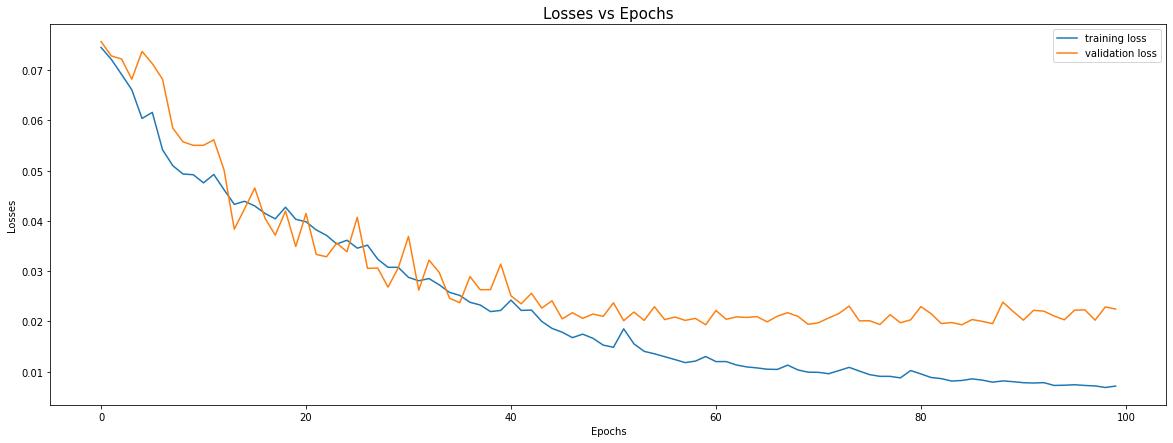

In [42]:
plt.figure(figsize = (20,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses vs Epochs', fontsize = 15)

In [43]:
from keras.models import load_model
model = load_model('./cancer_image_model.h5')

In [44]:
y_pred = model.predict(X_test)

In [45]:
print(y_pred.shape)

(39, 128, 128, 1)


# Predictions

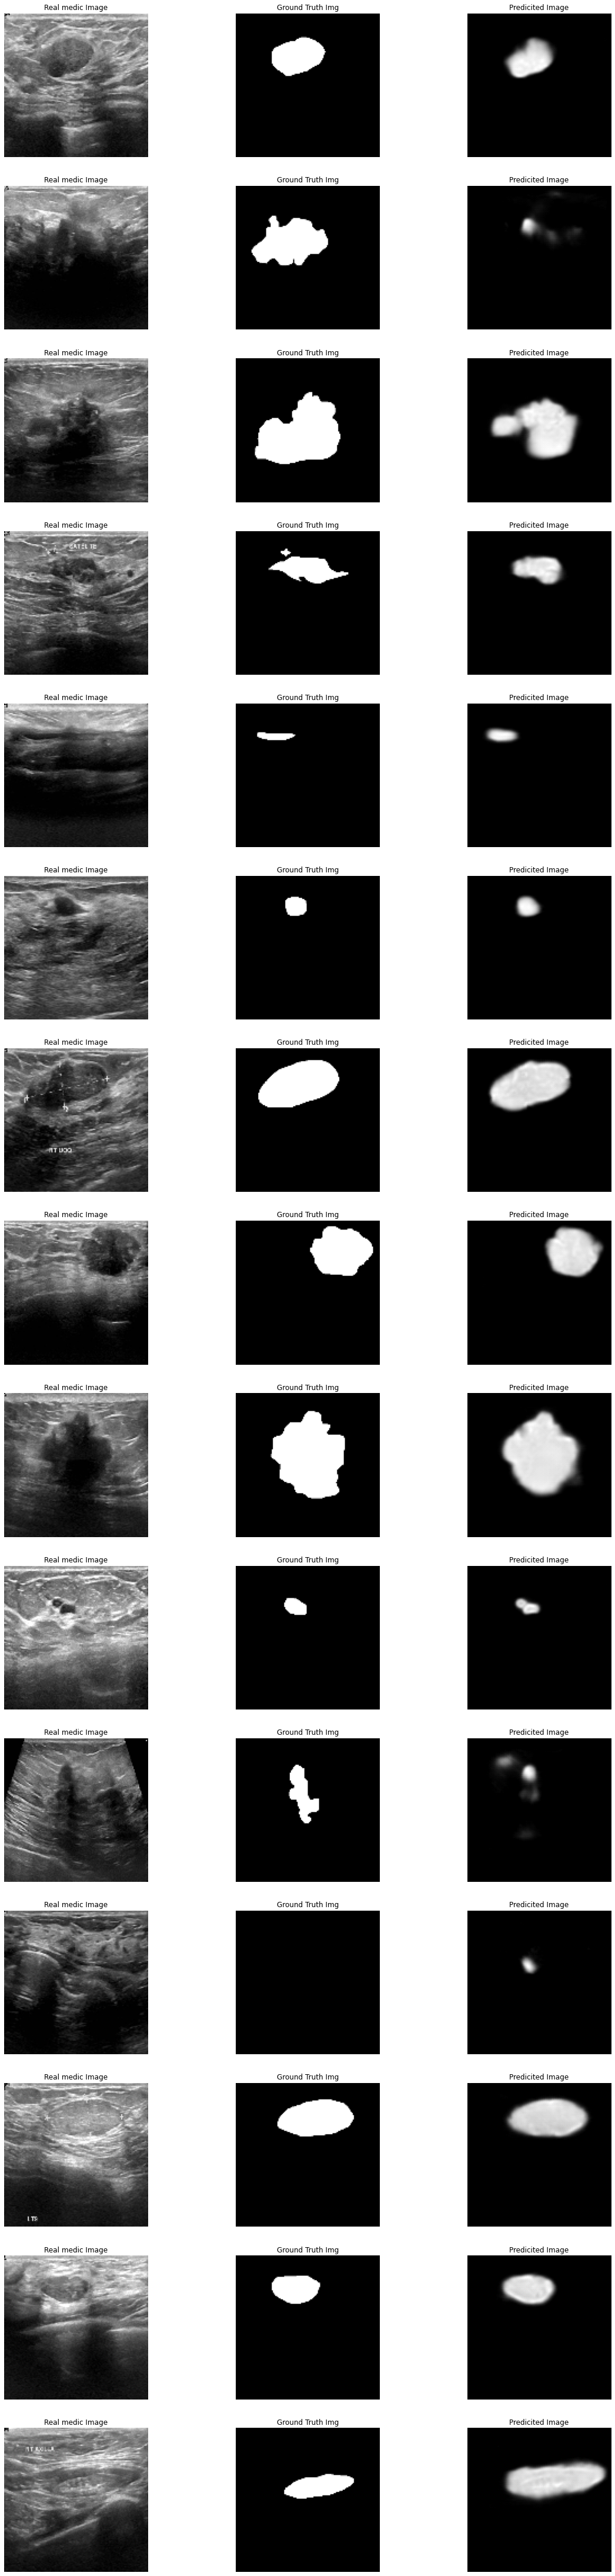

In [46]:
plt.figure(figsize = (20,80))

i = 0
x = 0
while i < 45 :
    
    plt.subplot(15,3,i+1)
    plt.imshow(X_test[x].reshape(128,128), 'gray')
    plt.title('Real medic Image')
    plt.axis('off')
    
    plt.subplot(15,3,i+2)
    plt.imshow(y_test[x].reshape(128,128), 'gray')
    plt.title('Ground Truth Img')
    plt.axis('off')
    
    plt.subplot(15,3,i+3)
    plt.imshow(y_pred[x].reshape(128,128), 'gray')
    plt.title('Predicited Image')
    plt.axis('off')
    
    x += 1
    i += 3
plt.show()

# Classifier

In [47]:
info = [
    'benign'   ,  # 0
    'normal'   ,  # 1
    'malignant',  # 2
]

In [48]:
path = 'drive/MyDrive/Dataset_BUSI_with_GT/'

In [49]:
X = []
y = []

label_num = -1

for label_class in os.listdir(path) :
    
    new_path   = path + label_class
    label_num += 1
    
    for img in os.listdir(new_path) :
        if 'mask' not in img :
            
            y.append(label_num)
            x = cv2.imread(path + label_class +'/'+img, cv2.IMREAD_GRAYSCALE)
            X.append(img_to_array(Image.fromarray(cv2.resize(x, (128,128)))))

In [50]:
X = np.array(X)
y = np.array(y)

In [51]:
X/= 255.0

In [55]:
from tensorflow.keras.utils import to_categorical

In [56]:
y = to_categorical(y)

In [57]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 3)


In [58]:
print(X.min())
print(X.max())

0.0
1.0


(-0.5, 127.5, 127.5, -0.5)

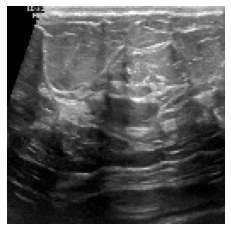

In [59]:
plt.imshow(X[0].reshape(128,128), 'gray')
plt.axis('off')

In [60]:
from keras.models import load_model

In [61]:
localize = load_model('./cancer_image_model.h5')

In [62]:
M = localize.predict(X)

0.0
1.1832322


(-0.5, 127.5, 127.5, -0.5)

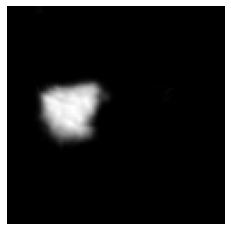

In [65]:
print(M.min())
print(M.max())

plt.imshow(M[0].reshape(128,128), 'gray')
plt.axis('off')

# Data distribution

In [66]:
import pandas
import seaborn

Text(0.5, 1.0, 'Distribution of classes accross the entire dataset')

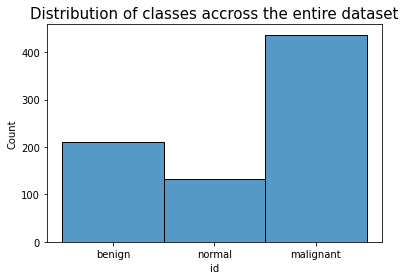

In [67]:
seaborn.histplot(data = pandas.DataFrame({'id' : [info[p] for p in np.argmax(y, axis = 1)]}), x = 'id')
plt.title('Distribution of classes accross the entire dataset', fontsize = 15)

<div style = "text-align: justify">Although this is a imbalanced distribution, a model can easily be developed that does well in classification task. This is beause these images have clear distinctions among them.</div>

# train-test split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(M, y, test_size = 0.1, shuffle = True, random_state = 1)

In [69]:
print(X_train.shape)
print(y_train.shape)

(702, 128, 128, 1)
(702, 3)


In [70]:
print(X_test.shape)
print(y_test.shape)

(78, 128, 128, 1)
(78, 3)


In [71]:
from numpy.random import randint

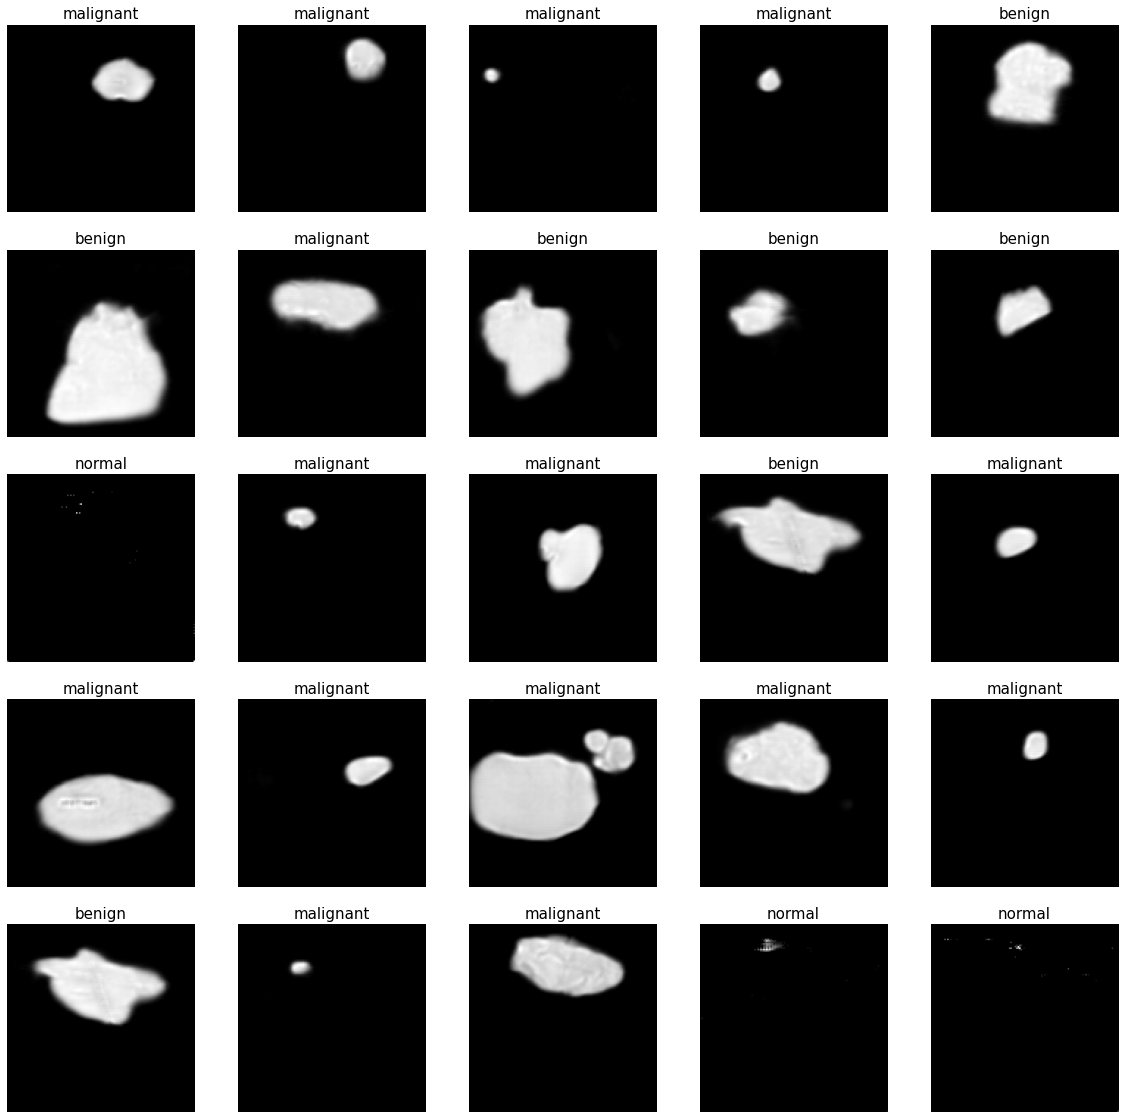

In [73]:
plt.figure(figsize = (20,20))
i = 0
SIZE = 702
while i < 25 :
    
    x = randint(0, SIZE)
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[x].reshape(128,128), 'gray')
    plt.title(f'{info[np.argmax(y_train[x])]}', fontsize = 15)
    plt.axis('off')
    
    i += 1
plt.show()

# Data augmentation

In [74]:
from keras.preprocessing.image import ImageDataGenerator

In [75]:
train_gen = ImageDataGenerator(horizontal_flip = True, rotation_range = 15, width_shift_range = [-10, 10], height_shift_range = [-10, 10], zoom_range = [0.80, 1.00])

In [76]:
train_gen.fit(X_train)

In [77]:
pointer = train_gen.flow(X_train, y_train)

In [78]:
trainX, trainy = pointer.next()

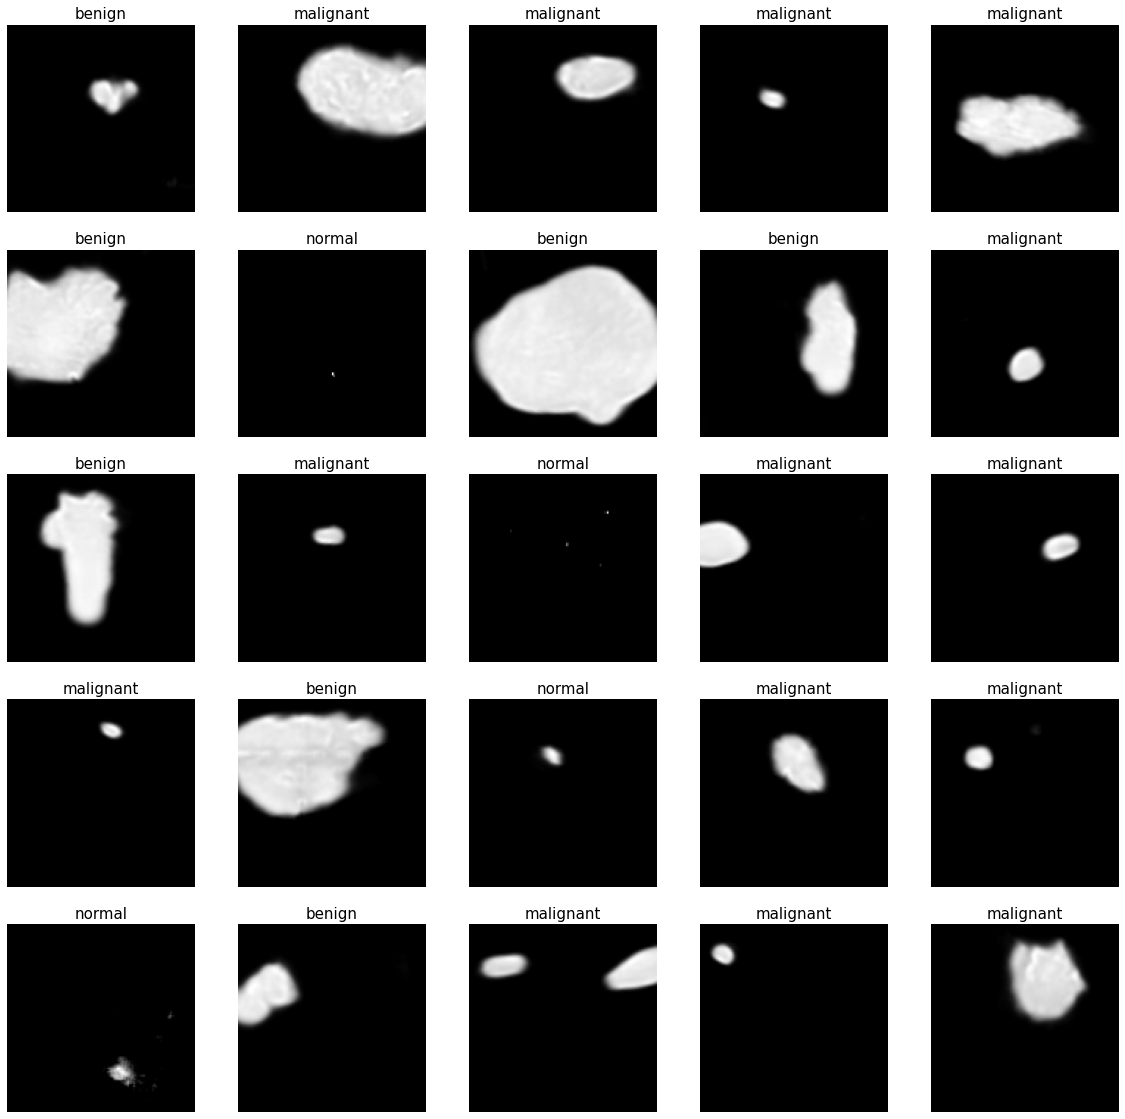

In [80]:
plt.figure(figsize = (20,20))

i = 0

while i < 25 :
    
    plt.subplot(5, 5, i+1)
    plt.imshow(trainX[i].reshape(128,128), 'gray')
    plt.title(f'{info[np.argmax(trainy[i])]}', fontsize = 15)
    plt.axis('off')
    
    i += 1
plt.show()

# make CNN model

In [83]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [84]:
def conv_block (filterx) :
    
    model = Sequential()
    
    model.add(Conv2D(filterx, (3,3), strides = 1, padding = 'same', kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    
    model.add(MaxPooling2D())
    
    return model

def dens_block (hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx, kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    
    return model

In [85]:
def cnn (filter1, filter2, filter3, filter4, hidden1) :
    
    model = Sequential([
        
        Input((128,128,1,)),
        conv_block(filter1),
        conv_block(filter2),
        conv_block(filter3),
        conv_block(filter4),
        Flatten(),
        dens_block(hidden1),
        Dense(3, activation = 'softmax')
    ])
    
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0005), metrics = ['accuracy'])
    
    return model

In [86]:
model = cnn(32, 64, 128, 256, 32)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 32)        448       
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 64)        18752     
                                                                 
 sequential_2 (Sequential)   (None, 16, 16, 128)       74368     
                                                                 
 sequential_3 (Sequential)   (None, 8, 8, 256)         296192    
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 sequential_4 (Sequential)   (None, 32)                524448    
                                                                 
 dense_1 (Dense)             (None, 3)                

In [88]:
from tensorflow.keras.utils import plot_model

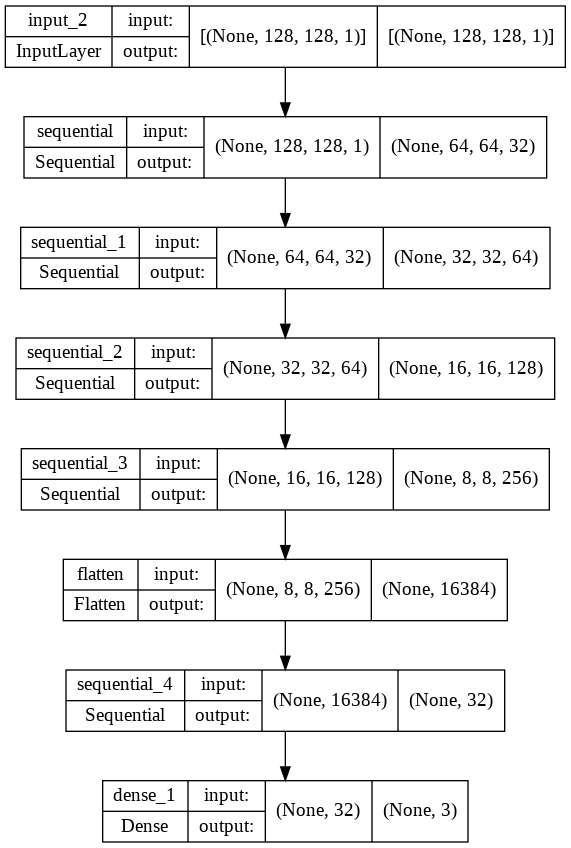

In [89]:
plot_model(model, 'cancer_classify.png', show_shapes = True)

# fit()

In [90]:
checkp = ModelCheckpoint('./valid_classifier.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)

In [91]:
history = model.fit(train_gen.flow(X_train, y_train, batch_size = 64), epochs = 400, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/400
11/11 [==============================] - ETA: 0s - loss: 4.4973 - accuracy: 0.6524
Epoch 1: val_loss improved from inf to 4.60358, saving model to ./valid_classifier.h5
11/11 [==============================] - 5s 263ms/step - loss: 4.4973 - accuracy: 0.6524 - val_loss: 4.6036 - val_accuracy: 0.1538
Epoch 2/400
11/11 [==============================] - ETA: 0s - loss: 4.0441 - accuracy: 0.6809
Epoch 2: val_loss improved from 4.60358 to 4.47928, saving model to ./valid_classifier.h5
11/11 [==============================] - 1s 116ms/step - loss: 4.0441 - accuracy: 0.6809 - val_loss: 4.4793 - val_accuracy: 0.1538
Epoch 3/400
11/11 [==============================] - ETA: 0s - loss: 3.6954 - accuracy: 0.7336
Epoch 3: val_loss did not improve from 4.47928
11/11 [==============================] - 1s 108ms/step - loss: 3.6954 - accuracy: 0.7336 - val_loss: 4.5313 - val_accuracy: 0.1538
Epoch 4/400
11/11 [==============================] - ETA: 0s - loss: 3.3651 - accuracy: 0.7479
Epoc

Text(0.5, 1.0, 'Loss val wrt. Epochs')

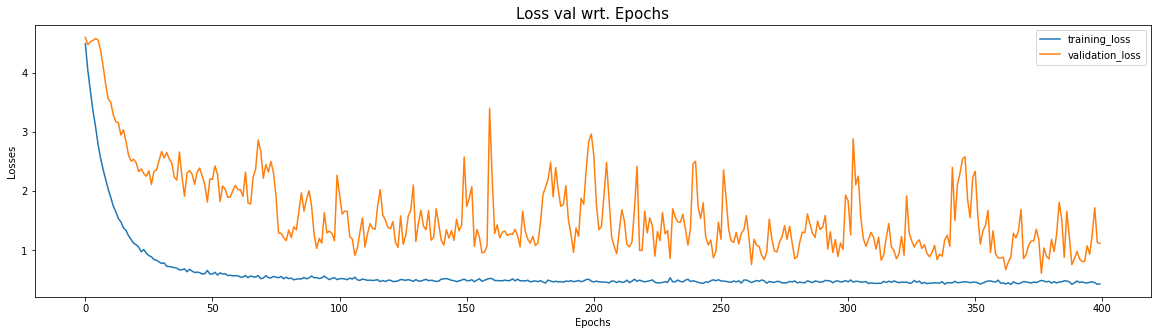

In [92]:
plt.figure(figsize = (20,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss val wrt. Epochs', fontsize = 15)

# Predictions

In [93]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [94]:
model = keras.models.load_model('./valid_classifier.h5')

In [95]:
y_pred = model.predict(X_test)

In [96]:
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [97]:
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names = info))

Accuracy : 0.8461538461538461
              precision    recall  f1-score   support

      benign       0.68      0.89      0.77        19
      normal       0.85      0.92      0.88        12
   malignant       0.95      0.81      0.87        47

    accuracy                           0.85        78
   macro avg       0.83      0.87      0.84        78
weighted avg       0.87      0.85      0.85        78



# Confusion matrix

In [98]:
cm = confusion_matrix(y_test,y_pred)

Text(0.5, 145.31999999999996, 'Predicted')

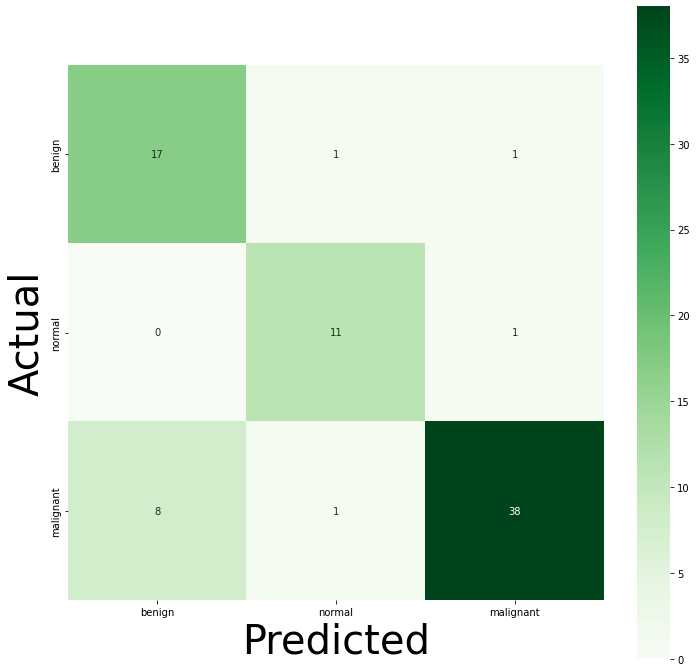

In [99]:
plt.figure(figsize = (12,12))
ax = seaborn.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

# Overall task
<div style = "text-align: justify">Now that the models are complete, we first get the mask for input image and then classify the tumor type <b>benign, malignant or normal</b> based on mask shape.</div>

In [127]:
image_path = [
    'drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (110).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (101).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (107).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/normal/normal (101).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/normal/normal (111).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/normal/normal (106).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (115).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (111).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (110).png',
]

In [102]:
from tensorflow.keras.models import load_model

# load models

In [103]:
classifier = load_model('./valid_classifier.h5')
localize = load_model('./cancer_image_model.h5')

# load images

In [131]:
testX = []
for img in image_path :
    testX.append(img_to_array(Image.fromarray(cv2.resize(cv2.imread(img, cv2.IMREAD_GRAYSCALE), (128,128)))))

In [132]:
testX = np.array(testX)
testX/= 255.0

In [133]:
print(testX.shape)
print(f'Minimum : {testX.min()}')
print(f'Maximum : {testX.max()}')

(10, 128, 128, 1)
Minimum : 0.0
Maximum : 1.0


(-0.5, 127.5, 127.5, -0.5)

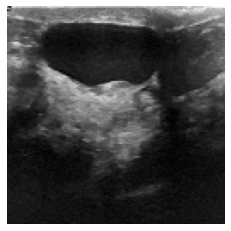

In [135]:
plt.imshow(testX[0].reshape(128,128), 'gray')
plt.axis('off')

# predict mask and label

In [136]:
predY = localize.predict(testX)

In [137]:
print(predY.shape)

(10, 128, 128, 1)


(-0.5, 127.5, 127.5, -0.5)

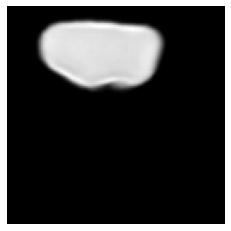

In [139]:
plt.imshow(predY[0].reshape(128,128), 'gray')
plt.axis('off')

In [140]:
print(predY.min())
print(predY.max())

0.0
1.0984002


In [141]:
pred_label = classifier.predict(predY)

[2 2 2 2 1 1 1 0 2 2]


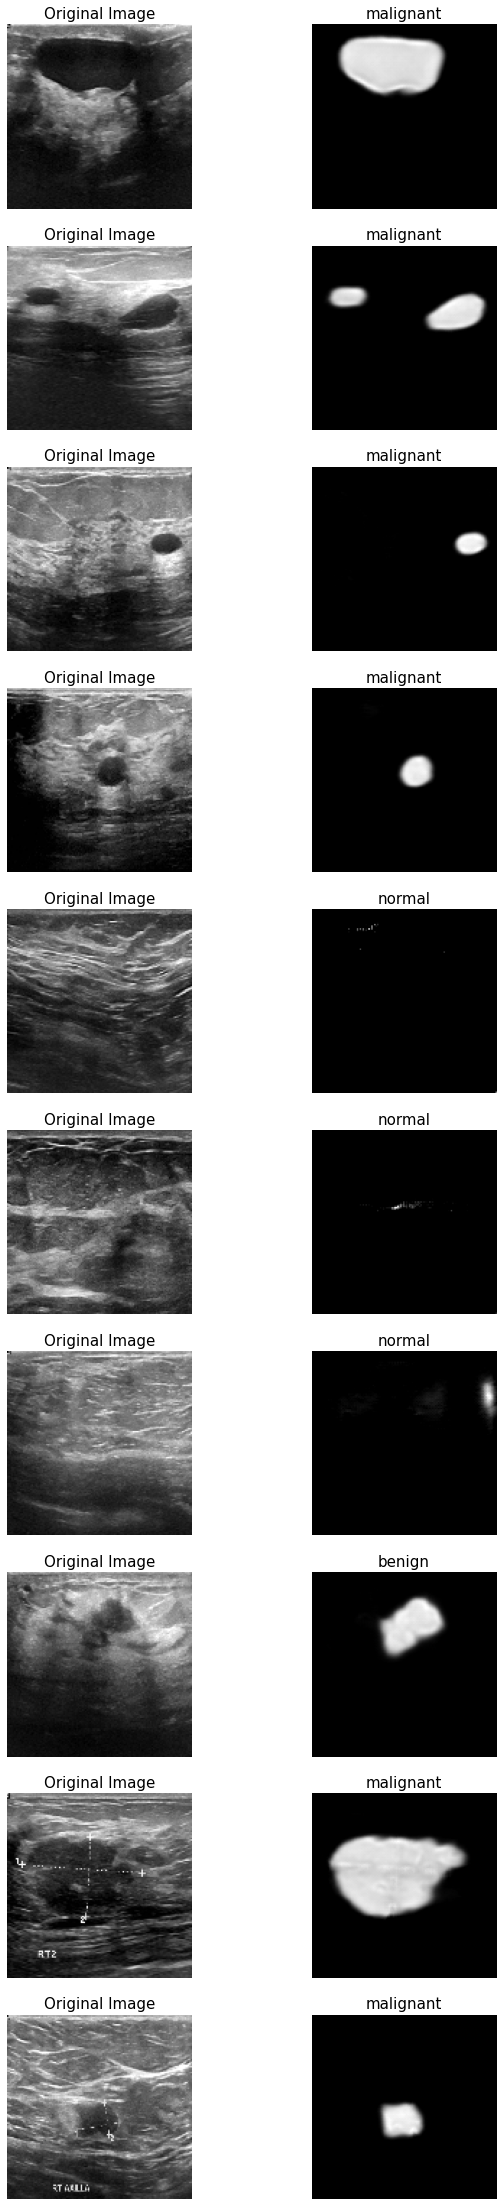

In [143]:
print(np.argmax(pred_label, axis = 1))
plt.figure(figsize = (10,40))

i = 0
j = 0
while i < 20 :
    
    plt.subplot(10,2,i+1)
    plt.imshow (testX[j].reshape(128,128), 'gray')
    plt.title('Original Image', fontsize = 15)
    plt.axis('off')
    
    plt.subplot(10,2,i+2)
    plt.imshow (predY[j].reshape(128,128), 'gray')
    plt.title(f'{info[np.argmax(pred_label[j])]}', fontsize = 15)
    plt.axis('off')
    
    j += 1
    i += 2
plt.show()